In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from matplotlib import pyplot
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Dense, Reshape
from tensorflow.keras.layers import Flatten, Input, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

w_init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

In [2]:
IMG_H = 64
IMG_W = 64 
IMG_C = 3

In [3]:
def save_plot(examples, epoch, n):
    examples = (examples + 1.0)/2.0
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i])
    filename = f"samples/generated_plot_epoch-{epoch+1}.png"
    plt.savefig(filename)
    plt.close()

In [4]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image)
    image = tf.image.resize_with_crop_or_pad(image,IMG_H, IMG_W)
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

In [5]:
def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size = 10240)
    dataset = dataset.map(load_image)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size = 4)
    return dataset

In [6]:
def deconv_block(inputs, num_filters, kernel_size, strides, bn = True):
    x = Conv2DTranspose(
        filters = num_filters,
        kernel_size = kernel_size,
        kernel_initializer = w_init,
        use_bias = False,
        padding = 'same',
        strides = strides)(inputs)
    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha = 0.2)(x)
    return x

In [7]:
def conv_block(inputs, num_filters, kernel_size, padding = 'same', strides = 2, activation = True):
    x = Conv2D(filters = num_filters,
        kernel_size = kernel_size,
        kernel_initializer = w_init,
        strides = strides,
        padding = padding
        )(inputs)
    
    if activation:
        x = LeakyReLU(alpha = 0.2)(x)
        x = Dropout(0.3)(x)
    return x

In [8]:
def generator(latent_dim):
    f = [16, 8, 4, 2, 1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    
    noise = Input(shape = (latent_dim, ), name = 'gen_noise_input')
    
    x = Dense(f[0] * filters * h_output * w_output, use_bias = False)(noise)

    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Reshape((h_output, w_output, f[0]*filters))(x)
    
    for i in range(1,5):
        x = deconv_block(x, num_filters = f[i]*filters, kernel_size = 5, strides = 2, bn = True)
    
    x = conv_block(x, num_filters = 3, kernel_size = 5, strides = 1, activation = False)
    
    fake = Activation('tanh')(x)
    
    return Model(noise, fake, name = 'generator')

In [9]:
def discriminator():
    f = [16, 8, 4, 2, 1]
    filters  = 64
    image_Input = Input(shape = (IMG_H, IMG_W, IMG_C))
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    
    x = image_Input
    for i in reversed(range(1,5)):
        x = conv_block(x, filters*f[i], kernel_size = 5, strides = 2)
    
    x = Flatten()(x)
    x = Dense(1)(x)
    
    return Model(image_Input, x, name = 'discriminator')

In [10]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, images):
        batch_size = tf.shape(images)[0]
        
        """TRAIN DISCRIMINATOR"""
        for _ in range(2):
            """For Fake Images"""
            random_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))
            generated_images = self.generator(random_vectors)
            generated_labels = tf.zeros([batch_size, 1])
            
            with tf.GradientTape() as d1tape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = d1tape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            
            """For Real Images"""
            labels = tf.ones([batch_size, 1])
            with tf.GradientTape() as d2tape:
                predictions = self.discriminator(images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = d2tape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            
            
        """TRAINING GENERATOR"""
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))
        fake_labels = tf.ones([batch_size, 1])
        
        with tf.GradientTape() as gtape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(fake_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        return {'d1_loss' : d1_loss, 'd2_loss' : d2_loss, 'g_loss' : g_loss}

In [11]:
batch_size = 128
EPOCHS = 100
LATENT_DIM = 128

images_path = glob('data/*')
print("Dataset Size: ", len(images_path))

dataset = tf_dataset(images_path, batch_size)

d_model = discriminator()
g_model = generator(LATENT_DIM)

d_model.summary()
g_model.summary()

Dataset Size:  21551
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (No

In [14]:
gan = GAN(d_model, g_model, LATENT_DIM)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True, label_smoothing = 0.1)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
gan.compile(d_optimizer, g_optimizer, loss_fn)

In [ ]:
n_samples = 25
noise = np.random.normal(size = (n_samples, LATENT_DIM))
for epoch in range(1):
    gan.fit(dataset, epochs = 1)
    g_model.save('saved_model/g_model.h5')
    d_model.save('saved_model/d_model.h5')
#     examples = g_model.predict(noise)
#     save_plot(examples, epoch, int(np.sqrt(n_samples)))

  4/169 [..............................] - ETA: 13:36 - d1_loss: 0.6748 - d2_loss: 0.2763 - g_loss: 0.7290

AxesImage(54,36;334.8x217.44)


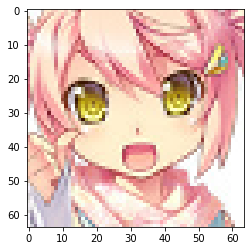

In [78]:
for img in dataset.take(1):
    print(plt.imshow((img[0] + 1)/2))

In [63]:
# img = g_model(np.random.normal(size = (1,128)))
# img = (img+1)/2.0
# # img = tf.sigmoid(img)
# plt.imshow(img[0])

In [61]:
dataset

<PrefetchDataset shapes: (None, 64, 64, None), types: tf.float32>